In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv('data/dm3/open100.csv')

In [3]:
print(train_data.shape)
train_data.head()

(27442600, 8)


,id,TX,TY,X,Y,Z,signal,data_ind
0,0,-0.198782,-0.647470,29682.042969,61717.070312,2586.0,0,1
1,1,-0.022600,-0.321373,64486.812500,34733.046875,42669.0,0,1
2,2,-0.071057,-0.204883,46626.039062,30379.675781,11637.0,0,1
3,3,-0.004688,-0.167113,48441.671875,59463.445312,71115.0,0,1
4,4,-0.097321,-0.273475,49847.132812,60116.535156,53013.0,0,1


In [4]:
print(train_data.data_ind.unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  74
  75  76  77  79  80  81  82  83  84  85  86  87  88  89  90  91  94  95
  96  97  98  99 100  37  73  78  92  93]


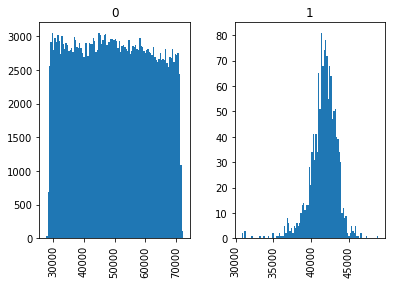

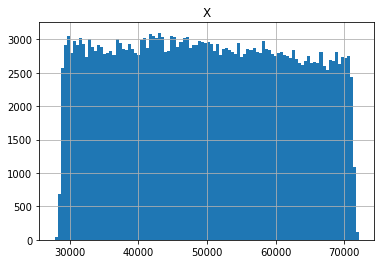

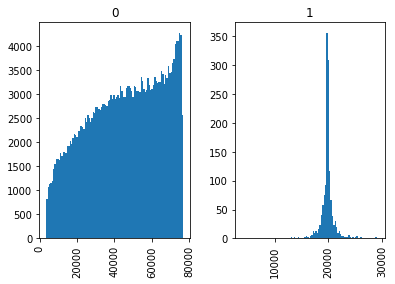

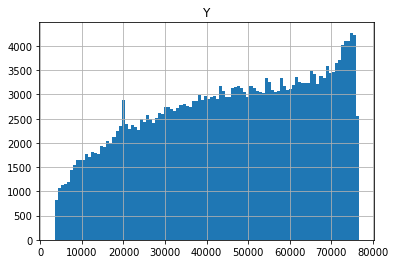

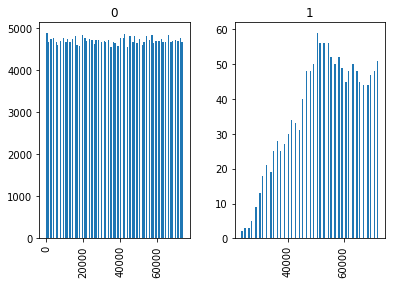

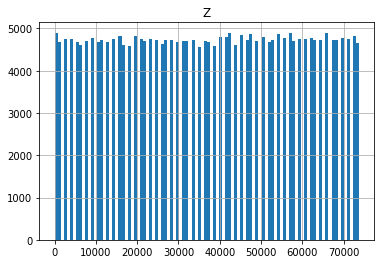

In [5]:
train_data.loc[train_data.data_ind == 1].hist(column='X', by='signal', bins=100)
train_data.loc[train_data.data_ind == 1].hist(column='X', bins=100)
train_data.loc[train_data.data_ind == 1].hist(column='Y', by='signal', bins=100)
train_data.loc[train_data.data_ind == 1].hist(column='Y', bins=100)
train_data.loc[train_data.data_ind == 1].hist(column='Z', by='signal', bins=100)
train_data.loc[train_data.data_ind == 1].hist(column='Z', bins=100)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5188302400>,
      dtype=object)

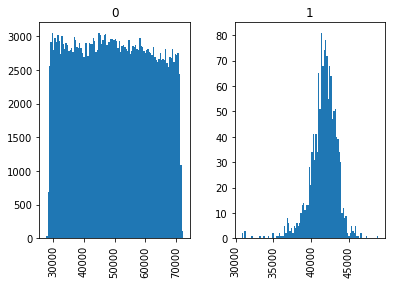

In [6]:
train_data.loc[train_data.data_ind == 1].hist(column='X', by='signal',bins=100)

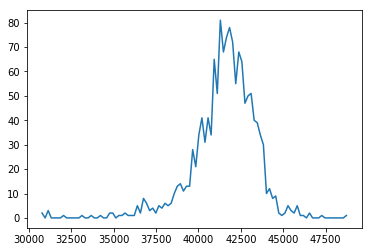

In [7]:
y, x = np.histogram(train_data[(train_data.data_ind == 1) & (train_data.signal == 1)].X, bins=100)
plt.plot(x[:-1], y)

In [8]:
def get_start(df, ind_id):
    if 'signal' in df.columns:
        df_ind = df[(df.data_ind == ind_id) & (df.signal == 1)].copy()
    else:
        df_ind = df[df.data_ind == ind_id].copy()
    y, x = np.histogram(df_ind.X, bins=100)
    id_y_max = np.argmax(y)
    df_x_max = df_ind[(df_ind.X > x[id_y_max - 1]) & (df_ind.X < x[id_y_max + 1])]
    return df_x_max[df_x_max.id == df_x_max.X.idxmax()]

get_start(train_data, 1)

,id,TX,TY,X,Y,Z,signal,data_ind
130977,130977,-0.101264,0.057423,41473.023438,19087.990234,58185.0,1,1


In [9]:
def update_data(df):
    new_df = []
    for data_ind in df.data_ind.unique():
        df_ind = df[df.data_ind == data_ind].copy()
        start = get_start(df, data_ind)
        df_ind['X'] = df_ind.X - start.iloc[0].X
        df_ind['Y'] = df_ind.Y - start.iloc[0].Y
        df_ind['Z'] = df_ind.Z - start.iloc[0].Z
#         df_ind['TX'] = np.tan(np.arctan(df_ind.TX) - np.arctan(start.iloc[0].TX))
#         df_ind['TY'] = np.tan(np.arctan(df_ind.TY) - np.arctan(start.iloc[0].TY))
        new_df.append(df_ind)
    return pd.concat(new_df)

In [10]:
test_data = pd.read_csv('data/dm3/test_50.csv')

In [11]:
print(test_data.shape)
test_data.head()

(13726164, 7)


,id,TX,TY,X,Y,Z,data_ind
0,0,0.295499,0.099981,60690.234375,23661.033203,25860.0,2701
1,1,0.100577,0.097563,47068.710938,53209.578125,72408.0,2701
2,2,-0.121270,0.052892,30749.601562,25000.320312,62064.0,2701
3,3,0.311124,0.240402,28850.226562,60354.363281,60771.0,2701
4,4,0.498214,0.128125,42120.714844,69713.304688,12930.0,2701


In [12]:
print(test_data.data_ind.unique())

[2701 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714
 2715 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728
 2729 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742
 2743 2744 2745 2746 2747 2748 2749 2750]


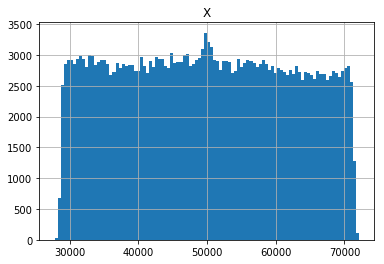

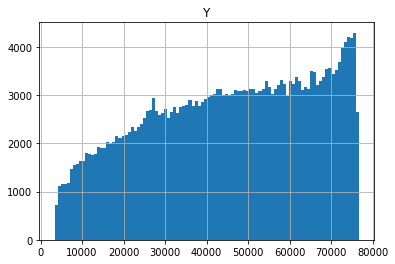

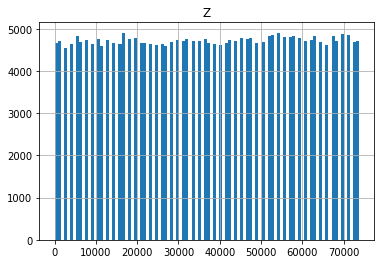

In [13]:
test_data.loc[test_data.data_ind == 2701].hist(column='X', bins=100)
test_data.loc[test_data.data_ind == 2701].hist(column='Y', bins=100)
test_data.loc[test_data.data_ind == 2701].hist(column='Z', bins=100)
plt.show()

In [14]:
get_start(test_data, 2701)

,id,TX,TY,X,Y,Z,data_ind
208190,208190,0.036759,0.315126,49964.089844,26088.941406,69822.0,2701


In [15]:
updated_train = update_data(train_data)
X_train = updated_train.drop(columns=['id', 'signal'])
y_train = updated_train.signal

In [290]:
lgb_train = lgb.Dataset(X_train, y_train)

In [291]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 15,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4
}

In [292]:
num_round = 20
lgb.cv(params, lgb_train, num_round, nfold=3)

{'auc-mean': [0.9563371140498972,
  0.9579813532596587,
  0.9627685960126889,
  0.978055099138186,
  0.9786594225520263,
  0.9780202439541726,
  0.9793805709025399,
  0.9800764895625766,
  0.9799761599901499,
  0.9793759401432524,
  0.9799795942604591,
  0.9804605811510884,
  0.9806762698715525,
  0.9805941712365741,
  0.9801984906181079,
  0.9799709015477621,
  0.9802265439686776,
  0.9820451475747864,
  0.9821904581423828,
  0.9832912732230193],
 'auc-stdv': [0.0066517870018110775,
  0.007507071604582728,
  0.0009221541992686336,
  0.000844193966895879,
  0.0003046369029411769,
  0.0005364514090742852,
  0.0009306365125356875,
  0.00043894325447620434,
  0.0004846705787259285,
  0.00029768036533103646,
  0.0003952768498638769,
  0.0006038722198944965,
  0.000566756053939704,
  0.00040080775321377714,
  0.0003496737733592095,
  0.00013395277956304265,
  0.00011127251092539833,
  0.0001809552332356053,
  0.00029120568128973367,
  0.00012602386671319566]}

In [293]:
num_round = 100
bst = lgb.train(params, lgb_train, num_round)

In [20]:
updated_test = update_data(test_data)
X_test = updated_test.drop(columns=['id'])

In [295]:
y_pred_test = bst.predict(X_test)

In [23]:
answer = pd.read_csv('data/dm3/example_50.csv')

In [24]:
answer.signal = y_pred_test

In [25]:
answer.to_csv('data/answer.csv', index=False)